<a href="https://colab.research.google.com/github/SelimSavas/AircraftSegmentationSAMandYOLOv8/blob/main/SAMandYOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv8 vs SAM Meta

## Library

In [ ]:
!pip install ultralytics
!pip install supervision
!pip install roboflow

import numpy as np
import cv2
import os
import sys
import torch
from roboflow import Roboflow

In [2]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd {HOME}

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

## Dataset (Roboflow)

In [6]:
IMAGE_NAME = '/content/airplane-2/test/images/00c315d7e84934bc_jpg.rf.faa540c666a1014811c24c48026bdff7.jpg'
IMG_SOURCE = cv2.imread(IMAGE_NAME)

In [7]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [8]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## YoloV8 - Creating BBox

In [80]:
from ultralytics import YOLO

yolo_model = YOLO('yolov8x.pt')
img = cv2.cvtColor(IMG_SOURCE, cv2.COLOR_BGR2RGB)
results = yolo_model.predict(source=img)


0: 640x640 10 persons, 1 car, 5 airplanes, 1 boat, 97.9ms
Speed: 0.5ms preprocess, 97.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


In [10]:
boxes_class_name = np.array([])
for r in results:
    for c in r.boxes.cls:
        boxes_class_name = np.append(boxes_class_name,yolo_model.names[int(c)])
boxes_class_name

array(['airplane', 'boat', 'person', 'airplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'airplane', 'airplane', 'car', 'person', 'airplane'], dtype='<U32')

In [11]:
k = 0
result_np_son = np.array([])
result_class = np.array([])
result_score = np.array([])
for result in results:
    result_np = np.array(result.boxes.data.cpu())

for i in result_np:
    result_np_son = np.append(result_np_son,i[:][:-2])
    result_class = np.append(result_class,i[:][-1:])
    result_score = np.append(result_score,i[:][-2:-1])
    k += 1


boxes = result_np_son.reshape((k,4))
boxes_class = result_class.reshape((k,))
boxes_score = result_score.reshape((k,))

In [12]:
boxes_class.shape

(17,)

In [13]:
type(boxes_class)

numpy.ndarray

In [14]:
boxes_class

array([          4,           8,           0,           4,           0,           0,           0,           0,           0,           0,           0,           0,           4,           4,           2,           0,           4])

## SAM - Segmentation

In [16]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_predictor = SamPredictor(sam)

[     4.1326      208.98      276.17      390.81]
[    0.95583     0.98391     0.98304]
4.0
airplane


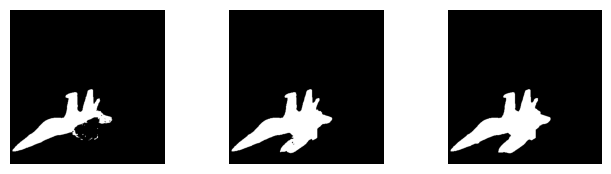

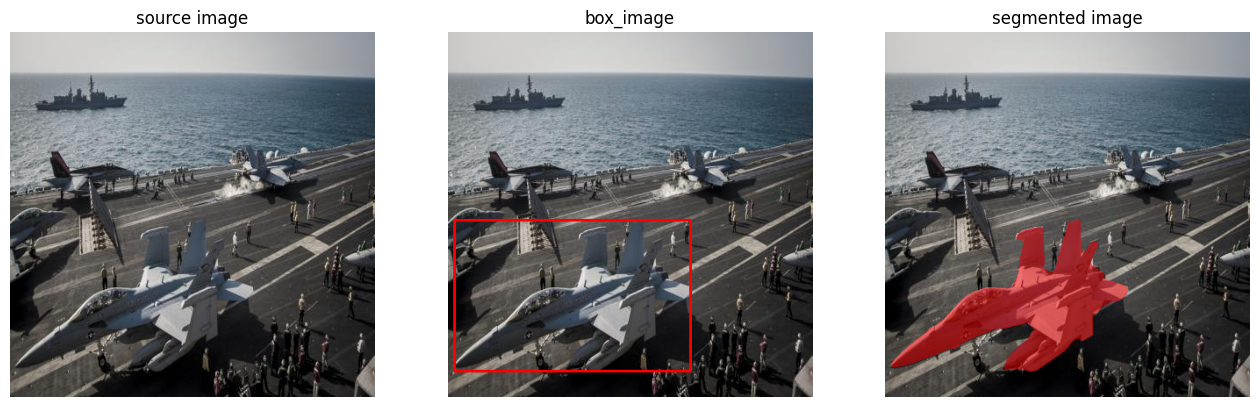

[     28.334       48.75       133.5      90.038]
[    0.97605     0.97987     0.97259]
8.0
boat


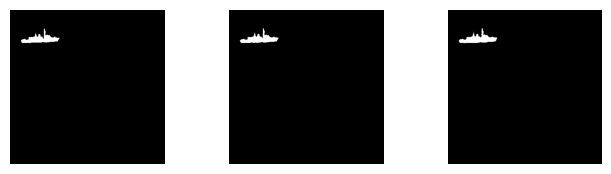

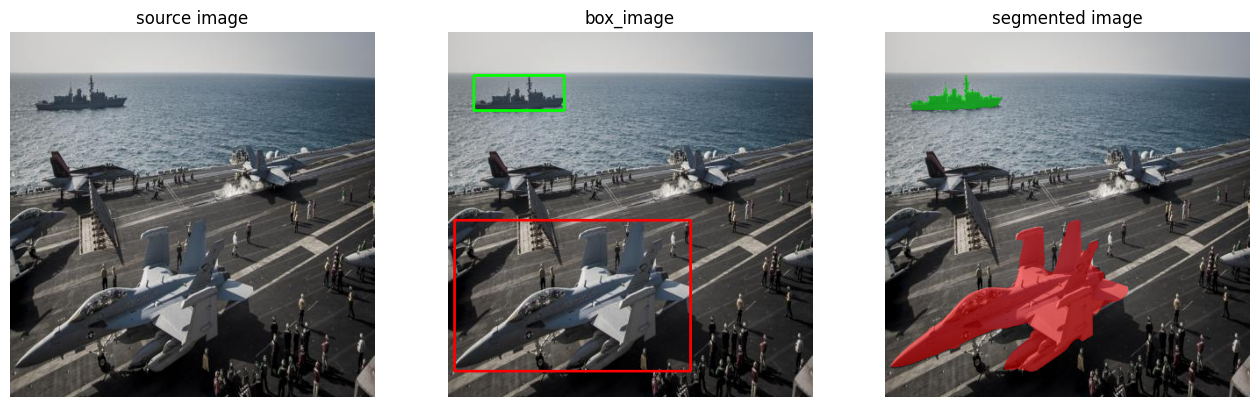

[     383.07      289.34      393.91      327.04]
[    0.94056     0.94713     0.93725]
0.0
person


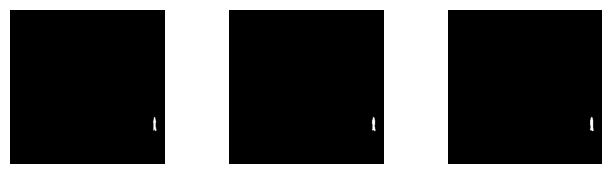

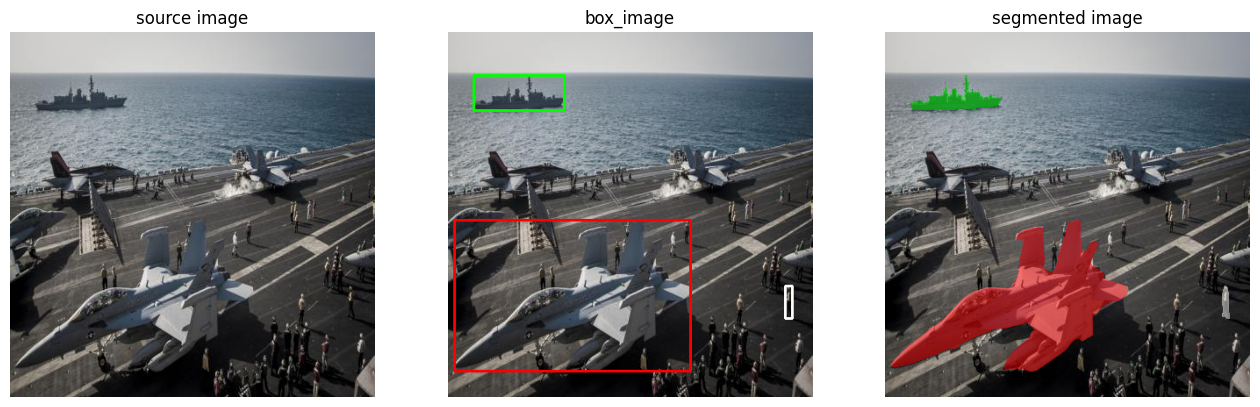

[    0.19044      199.77      79.178      288.53]
[    0.99047     0.99366     0.98512]
4.0
airplane


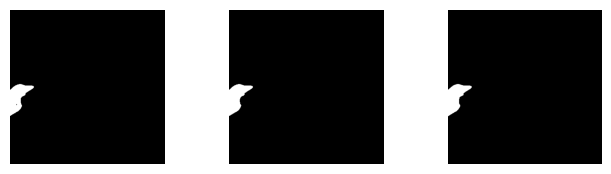

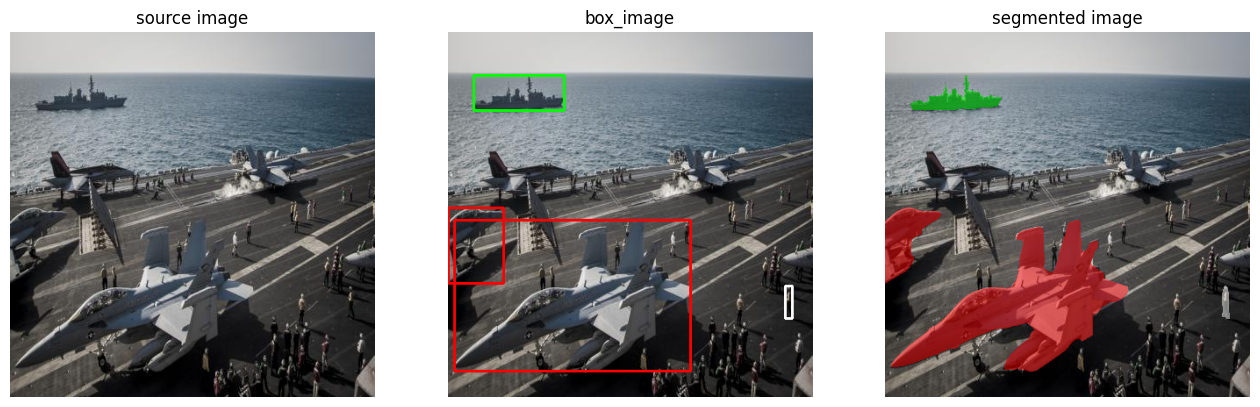

[     252.18      227.46      261.22      256.53]
[    0.94633     0.95157     0.94398]
0.0
person


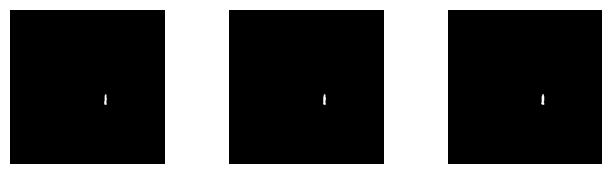

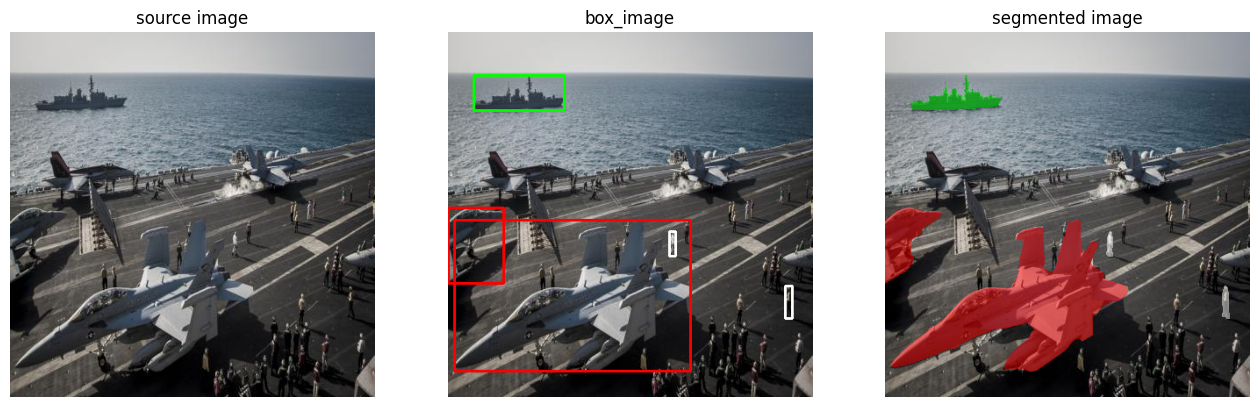

[     103.84      263.82      111.72      293.99]
[    0.95681     0.96156     0.94747]
0.0
person


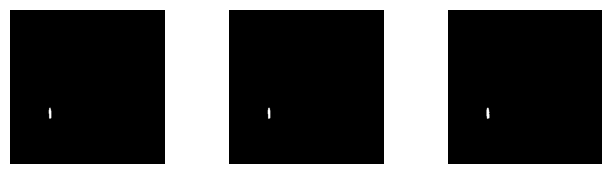

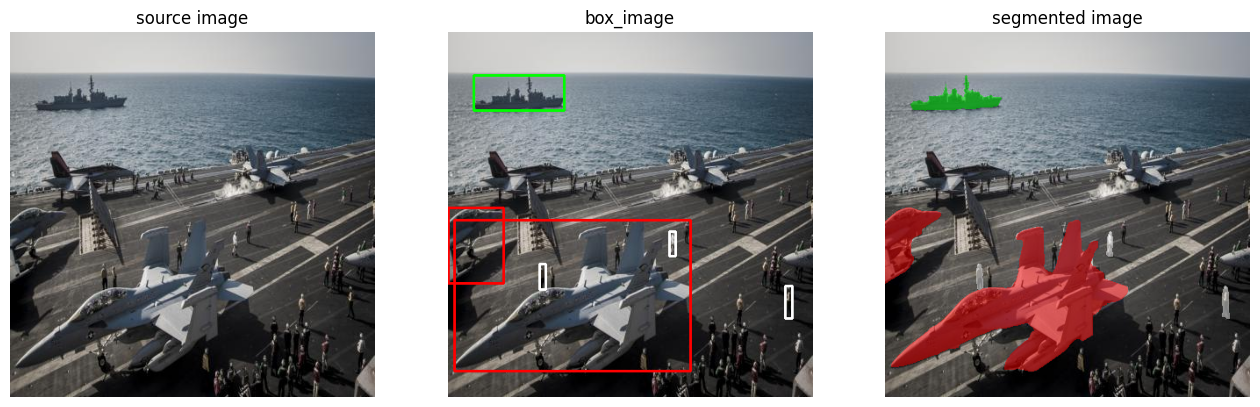

[     328.38      298.08      336.94      335.42]
[     0.9599     0.96176     0.94411]
0.0
person


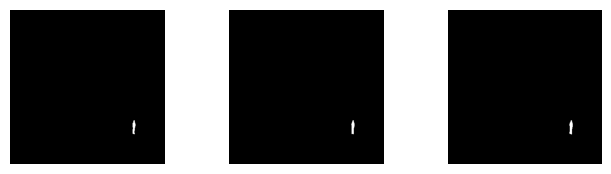

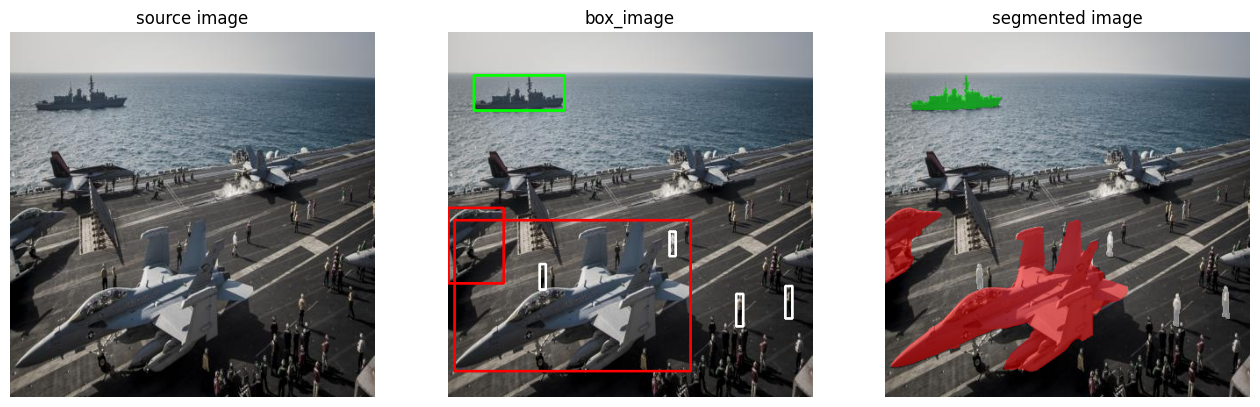

[      393.2      342.09      406.59       389.7]
[    0.92475     0.92653     0.91348]
0.0
person


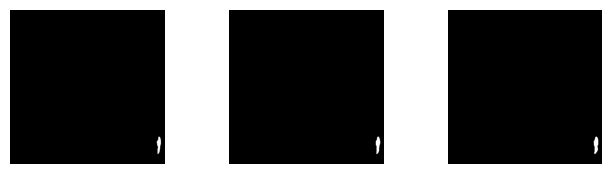

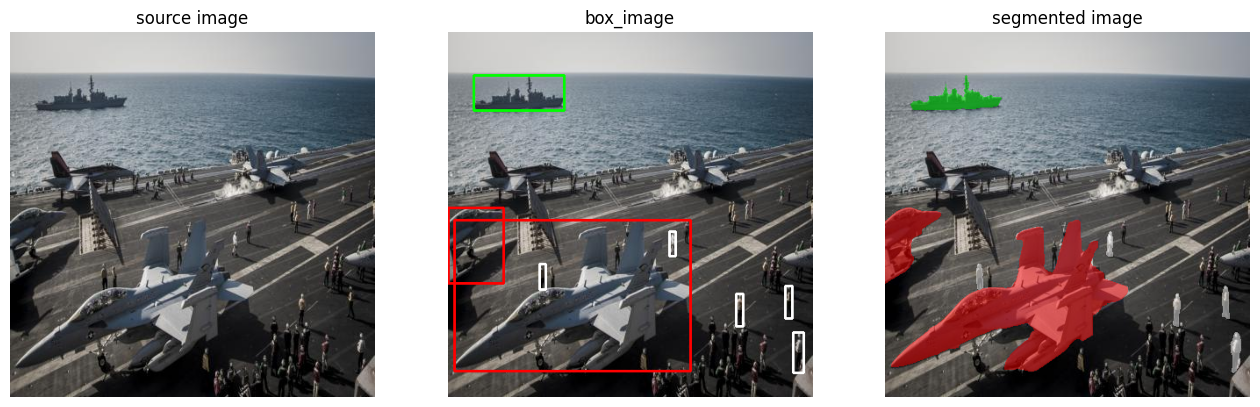

[     357.41      256.54      366.02      290.45]
[    0.93574      0.9431     0.92845]
0.0
person


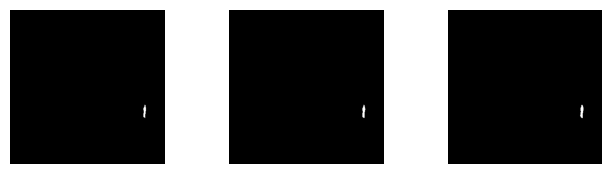

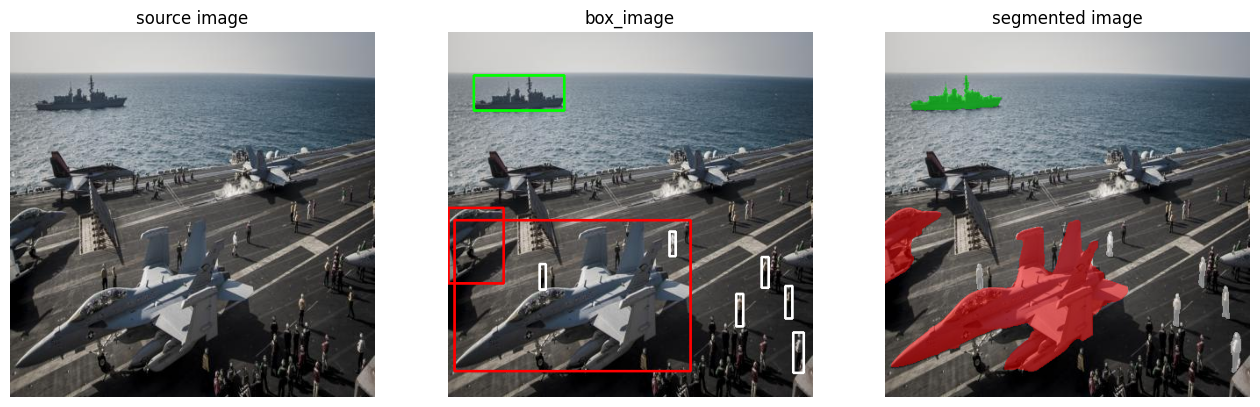

[     267.94      215.19      275.65      241.73]
[    0.93419     0.94435     0.93812]
0.0
person


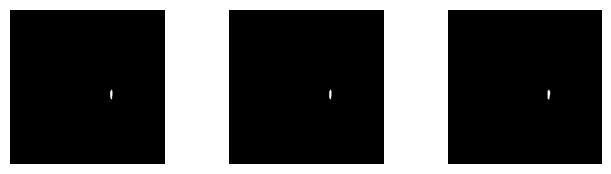

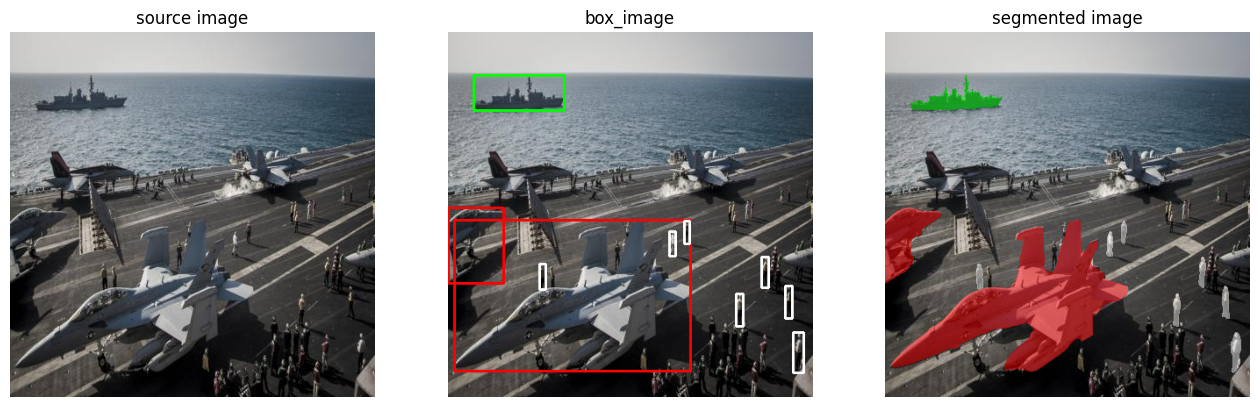

[     189.51      240.39       197.1      269.96]
[    0.94446     0.94675     0.93453]
0.0
person


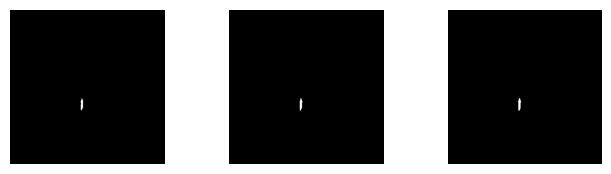

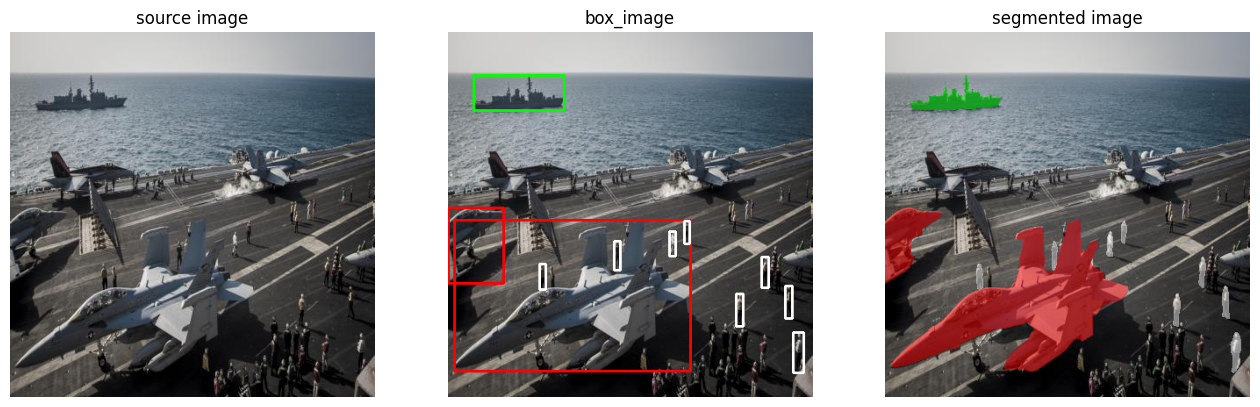

[     344.71      374.38      354.32       415.9]
[    0.97032     0.96995     0.95506]
0.0
person


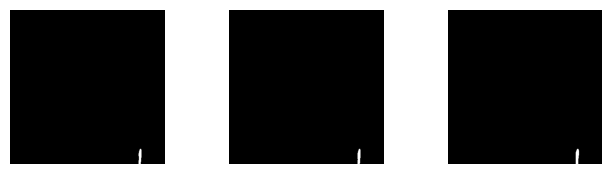

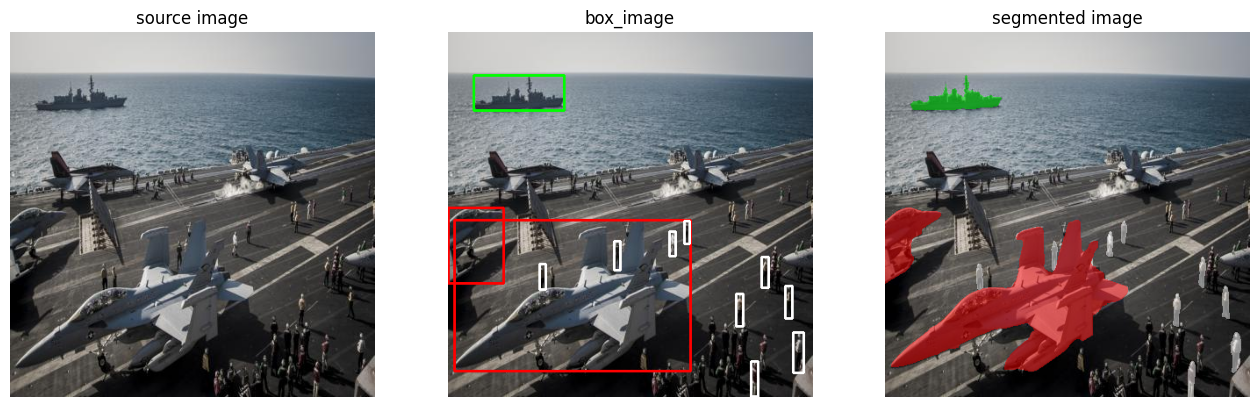

[      36.89      135.26       268.8      184.41]
[    0.94116     0.96575     0.92556]
4.0
airplane


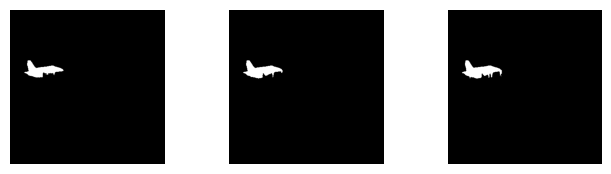

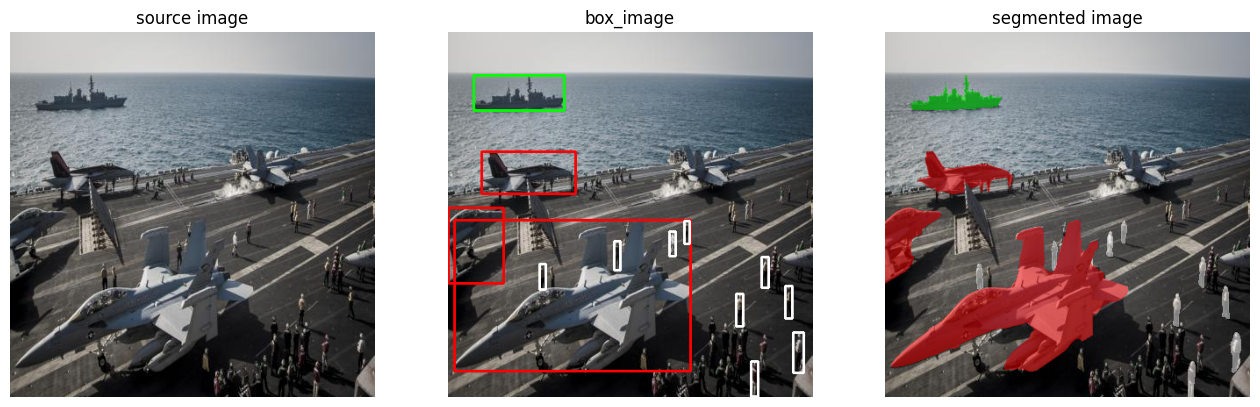

[     257.24      120.57      415.13      176.89]
[    0.71014     0.76966     0.89612]
4.0
airplane


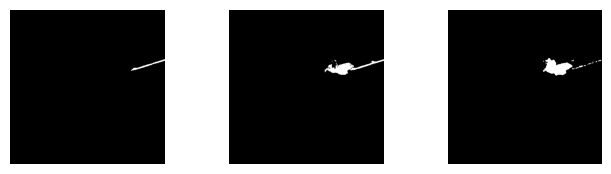

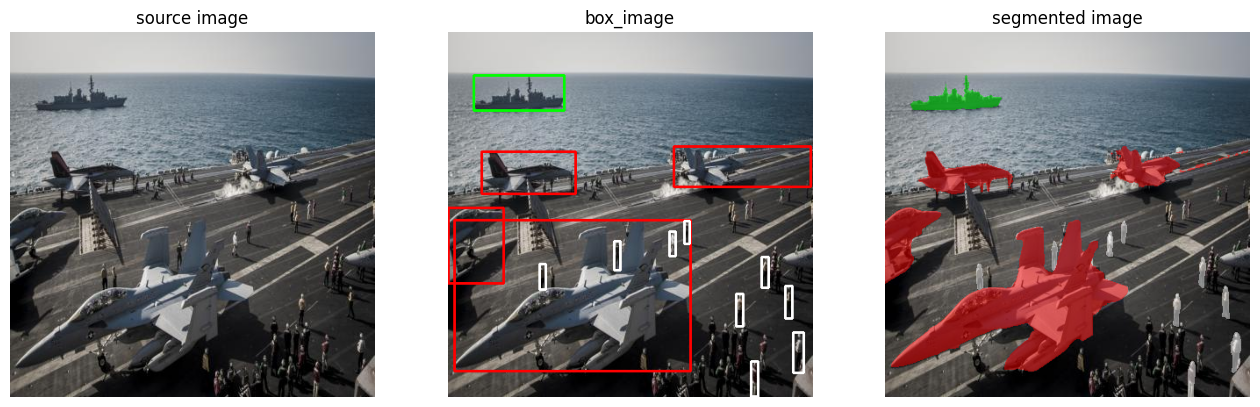

[     391.32      367.89      415.82      415.79]
[    0.95303     0.99837     0.99276]
2.0
car


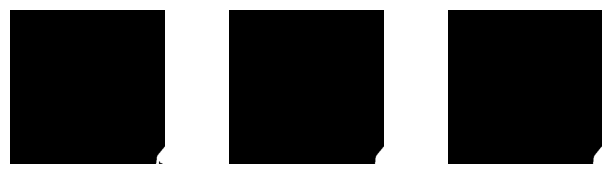

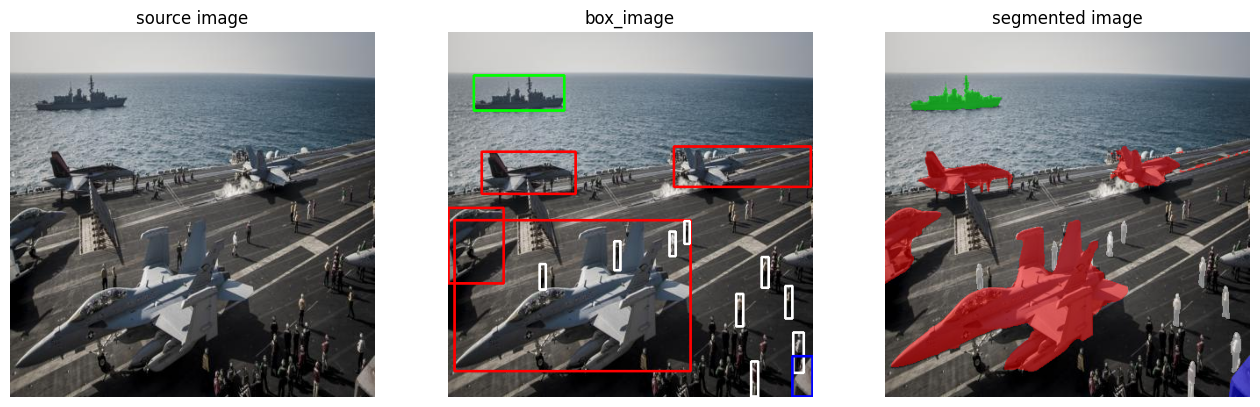

[     154.56      169.92      159.52       181.3]
[    0.93416     0.94473     0.93814]
0.0
person


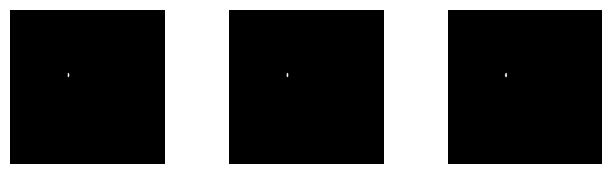

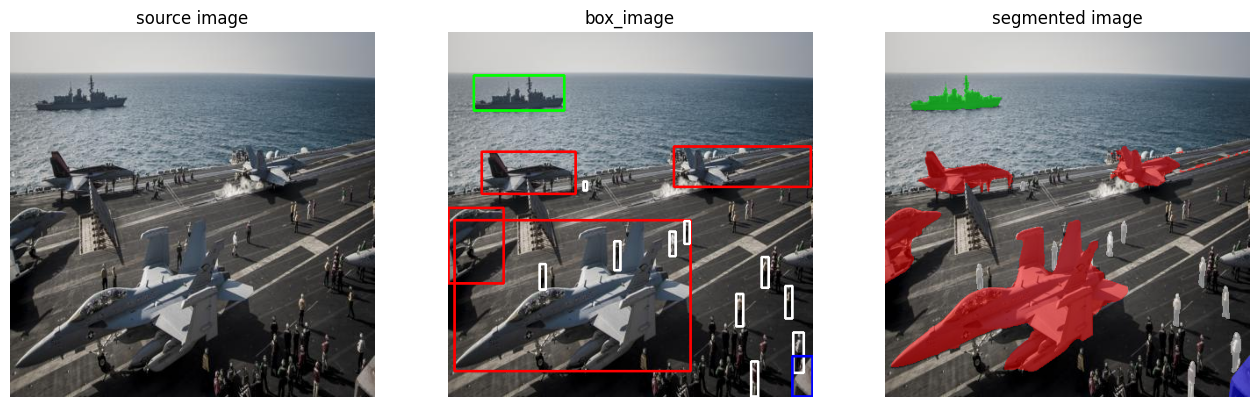

[     380.56      187.64      415.87      273.58]
[    0.95179     0.94494     0.92736]
4.0
airplane


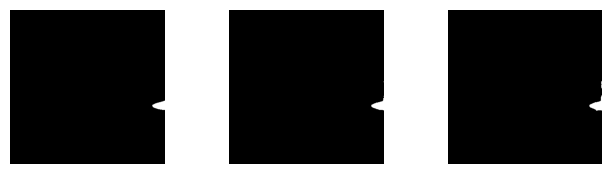

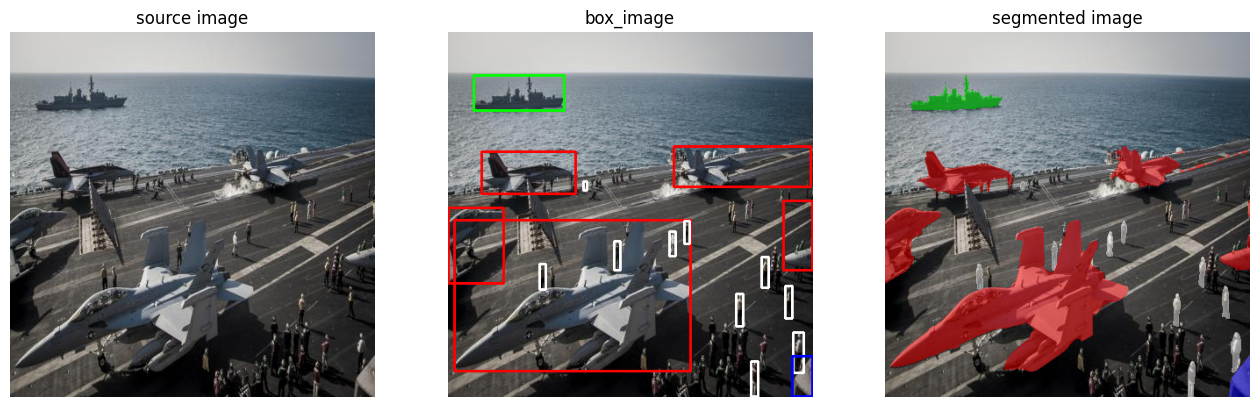

In [38]:
import supervision as sv

IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

merged_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
segmented_image = image_bgr.copy()
box_image = image_bgr.copy()
boxes_class_value = {'0':sv.Color.white(),'2':sv.Color.blue(),'4':sv.Color.red(),'8':sv.Color.green()}

i = 0

for box in boxes:
    mask_predictor.set_image(image_rgb)
    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )
    print(box)
    print(scores)
    print(str(boxes_class[i]))
    print(boxes_class_name[i])

    #merged_mask = np.logical_or(merged_mask, masks)

    box_annotator = sv.BoxAnnotator(color= boxes_class_value[str(int(boxes_class[i]))], text_padding=10)
    mask_annotator = sv.MaskAnnotator(color= boxes_class_value[str(int(boxes_class[i]))])

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks),
        mask=masks
    )

    detections = detections[detections.area == np.max(detections.area)]

    box_image = box_annotator.annotate(scene=box_image, detections=detections, skip_label=True)
    i += 1
    segmented_image = mask_annotator.annotate(scene=segmented_image, detections=detections)

    sv.plot_images_grid(
      images=masks,
      grid_size=(1, 3),
      size=(8, 2)
    )

    sv.plot_images_grid(
        images=[image_bgr,box_image, segmented_image],
        grid_size=(1, 3),
        titles=['source image','box_image','segmented image'],
        size=(16,8)
    ) 